# ARIMA Modeling

In this section we're going to begin fitting our data to ARIMA models and make predictions about the increase of COVID-19 cases in America.  

Due to time constraints, we will only be modeling the states with the top 5 highest number of cases.  If you remember from notebook 2, those states are California, Florida, Georgia, New York, and Texas.

Time to get started!

# Importing Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('national_positive_increase.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 57 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           256 non-null    object
 1   AK_positiveIncrease  256 non-null    int64 
 2   AL_positiveIncrease  256 non-null    int64 
 3   AR_positiveIncrease  256 non-null    int64 
 4   AS_positiveIncrease  256 non-null    int64 
 5   AZ_positiveIncrease  256 non-null    int64 
 6   CA_positiveIncrease  256 non-null    int64 
 7   CO_positiveIncrease  256 non-null    int64 
 8   CT_positiveIncrease  256 non-null    int64 
 9   DC_positiveIncrease  256 non-null    int64 
 10  DE_positiveIncrease  256 non-null    int64 
 11  FL_positiveIncrease  256 non-null    int64 
 12  GA_positiveIncrease  256 non-null    int64 
 13  GU_positiveIncrease  256 non-null    int64 
 14  HI_positiveIncrease  256 non-null    int64 
 15  IA_positiveIncrease  256 non-null    int64 
 16  ID_posit

In [3]:
# Rename 'Unnamed' to 'date'
df = df.rename(columns={'Unnamed: 0' : 'date'})

# Changing 'date' to date-time 
df['date'] = pd.to_datetime(df['date'])

# Set to index
df = df.set_index('date')

df = df.asfreq('D')

df.head()

,AK_positiveIncrease,AL_positiveIncrease,AR_positiveIncrease,AS_positiveIncrease,AZ_positiveIncrease,CA_positiveIncrease,CO_positiveIncrease,CT_positiveIncrease,DC_positiveIncrease,DE_positiveIncrease,...,TN_positiveIncrease,TX_positiveIncrease,UT_positiveIncrease,VA_positiveIncrease,VI_positiveIncrease,VT_positiveIncrease,WA_positiveIncrease,WI_positiveIncrease,WV_positiveIncrease,WY_positiveIncrease
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Alright, now that the dataframe is loaded up, let's subset the data of our top 5 states into their own dataframes.

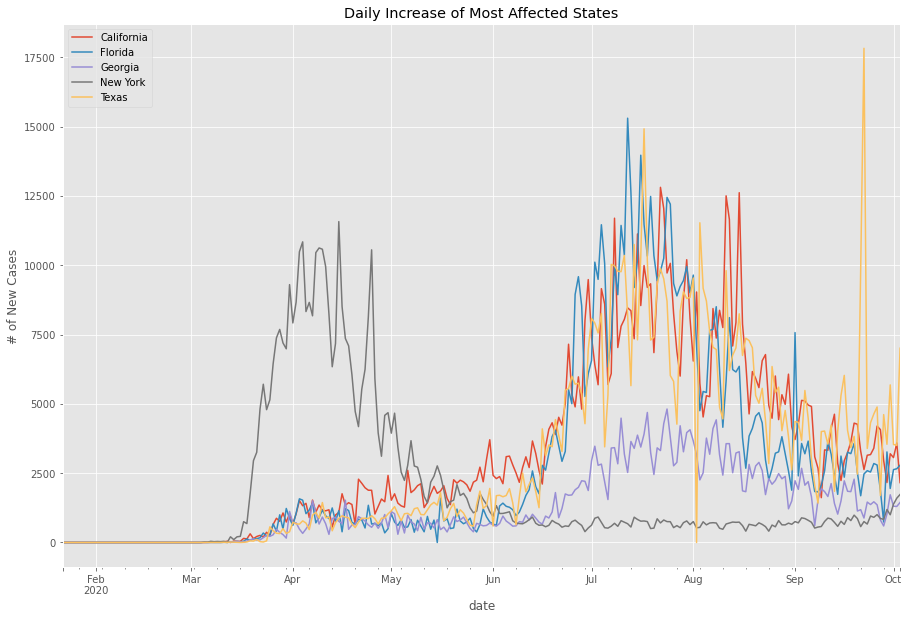

In [4]:
# California
ca = df['CA_positiveIncrease']
ca.plot(figsize=(15, 10), label='California')

# Florida
fl = df['FL_positiveIncrease']
fl.plot(figsize=(15, 10), label='Florida')

# Georgia
ga = df['GA_positiveIncrease']
ga.plot(figsize=(15, 10), label='Georgia')

# New York
ny = df['NY_positiveIncrease']
ny.plot(figsize=(15, 10), label='New York')

# Texas
tx = df['TX_positiveIncrease']
tx.plot(figsize=(15, 10), label='Texas')

plt.ylabel('# of New Cases')
plt.title('Daily Increase of Most Affected States')
plt.legend()
plt.show();

Awesome! We remember this messy plot from notebook 2!  Now, since we only have data between the end of January and the beginning of October, we shouldn't need to resample.  256 values per state is low enough, all things considered. If we resampled by the week, that would leave us with ~ 36 weeks, which might not be a enough data to get accurate data.  

# Auto-Correlation and Decomposition

While the very fact that we're dealing with a disease, and that people's exposure risk and immune systems are all different, I think it's safe to say that there is no seasonality (yet, and hopefully it stays that way).  Let's just check just to be sure though.

In [5]:
def lag(df, n):
    '''
    Input: Dataframe and 'n' number of periods(int)
    Output: Dataframe that contains concatenation of the lag shifted data and 
    original dataframe.
    '''
    # Shift data by 'n' number of periods
    shift = df.shift(periods=n)
    
    # Concat new data with original dataframe
    concat = pd.concat([shift, df], axis=1)
    
    return concat

In [6]:
# California Auto-Correlation
ca_lag_1 = lag(ca, 1)

# Check correlation after day lag
ca_lag_1.corr()

,CA_positiveIncrease,CA_positiveIncrease
CA_positiveIncrease,1.000000,0.925779
CA_positiveIncrease,0.925779,1.000000


Ok, as to be expected, it's very correlated after a single lag (equal to 1 day). Let's take a look at correlation after 7-days. 

In [7]:
ca_lag_7 = lag(ca, 7)
ca_lag_7.corr()

,CA_positiveIncrease,CA_positiveIncrease
CA_positiveIncrease,1.000000,0.878137
CA_positiveIncrease,0.878137,1.000000


That's actually a pretty strong correlation after a week.  Because COVID-19 has an incubation period of up to 14 days, let's try 14 next.

In [8]:
ca_lag_14 = lag(ca, 14)

ca_lag_14.corr()

,CA_positiveIncrease,CA_positiveIncrease
CA_positiveIncrease,1.000000,0.816383
CA_positiveIncrease,0.816383,1.000000


This is very interesting. There is still very high correlation.  Let's plot this out.

<Figure size 1440x1008 with 0 Axes>

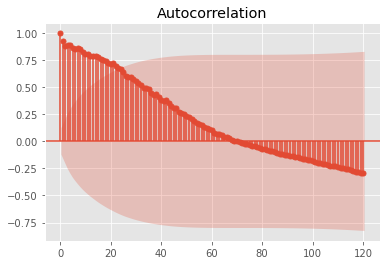

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(20,14))
plot_acf(ca, lags = 120);

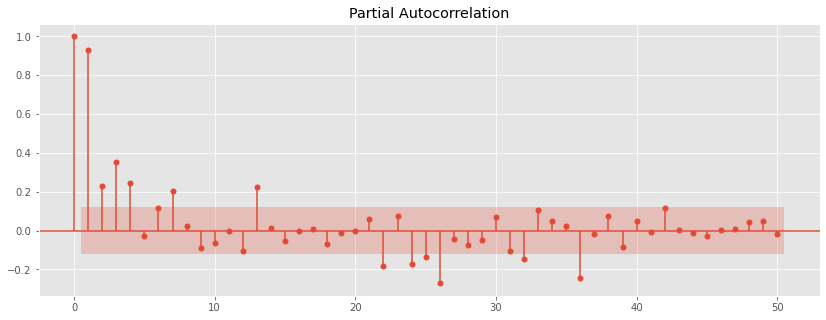

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf

from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_pacf(ca, lags=50);

Time to check if the other 4 states are this auto-correlated.  

In [11]:
# Georgia
ga_lag_14 = lag(ga, 14)

# New York
ny_lag_14 = lag(ny, 14)

# Florida 
fl_lag_14 = lag(fl, 14)

# Texas
tx_lag_14 = lag(tx, 14)

                     GA_positiveIncrease  GA_positiveIncrease
GA_positiveIncrease              1.00000              0.85653
GA_positiveIncrease              0.85653              1.00000


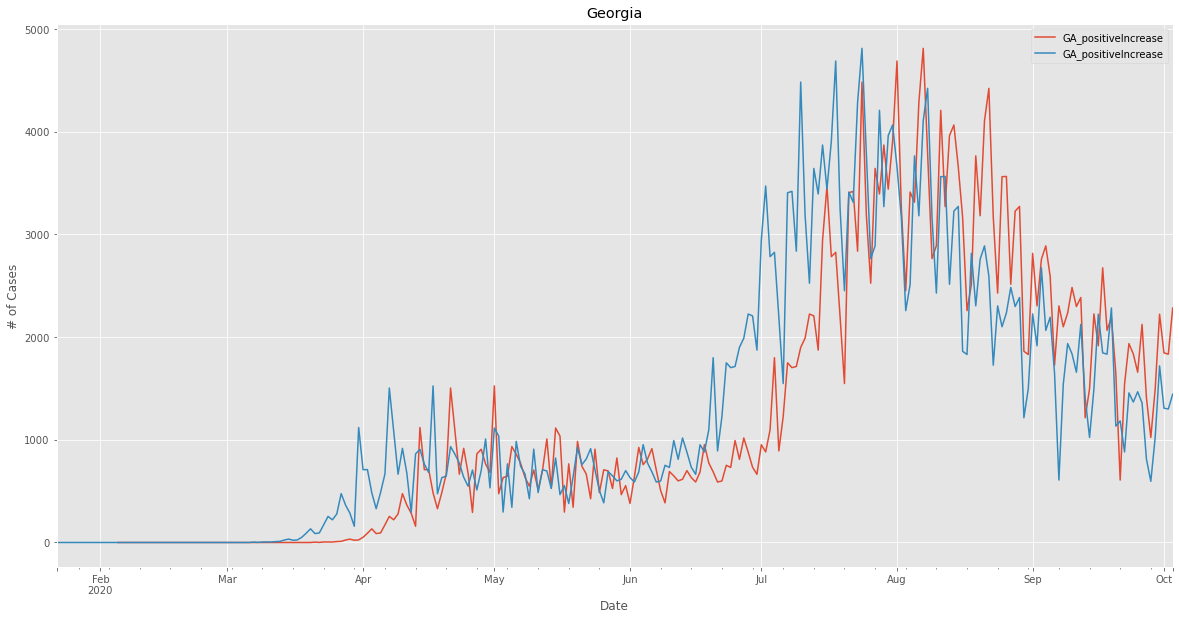

-------------------------------------------------------------
                     NY_positiveIncrease  NY_positiveIncrease
NY_positiveIncrease             1.000000             0.663926
NY_positiveIncrease             0.663926             1.000000


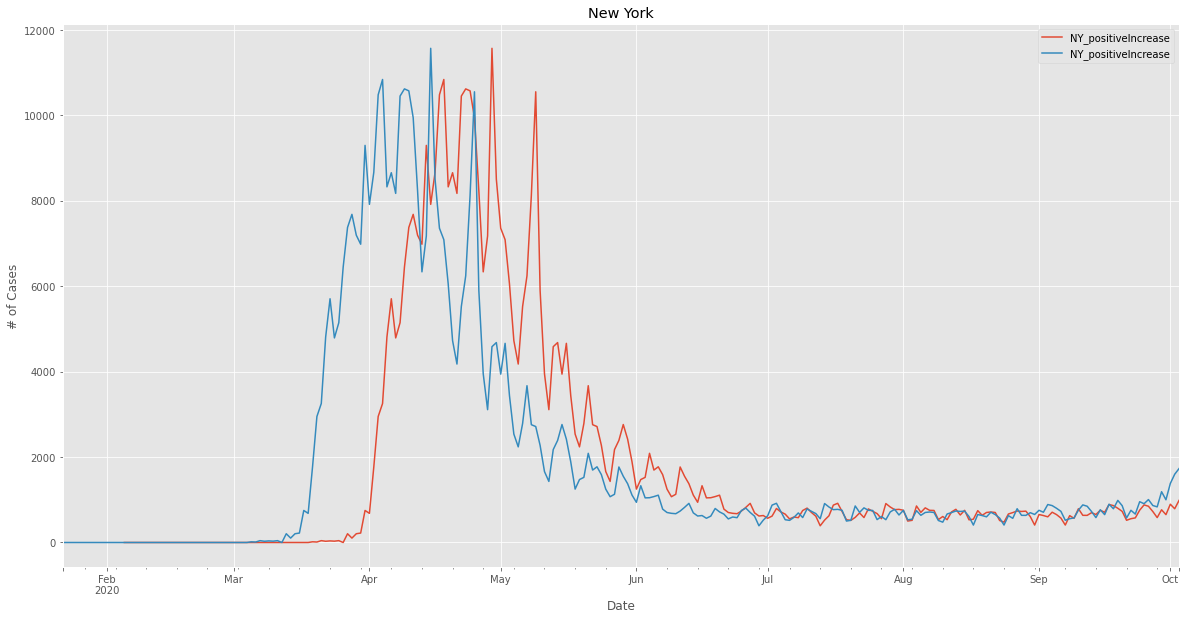

-------------------------------------------------------------
                     FL_positiveIncrease  FL_positiveIncrease
FL_positiveIncrease             1.000000             0.807526
FL_positiveIncrease             0.807526             1.000000


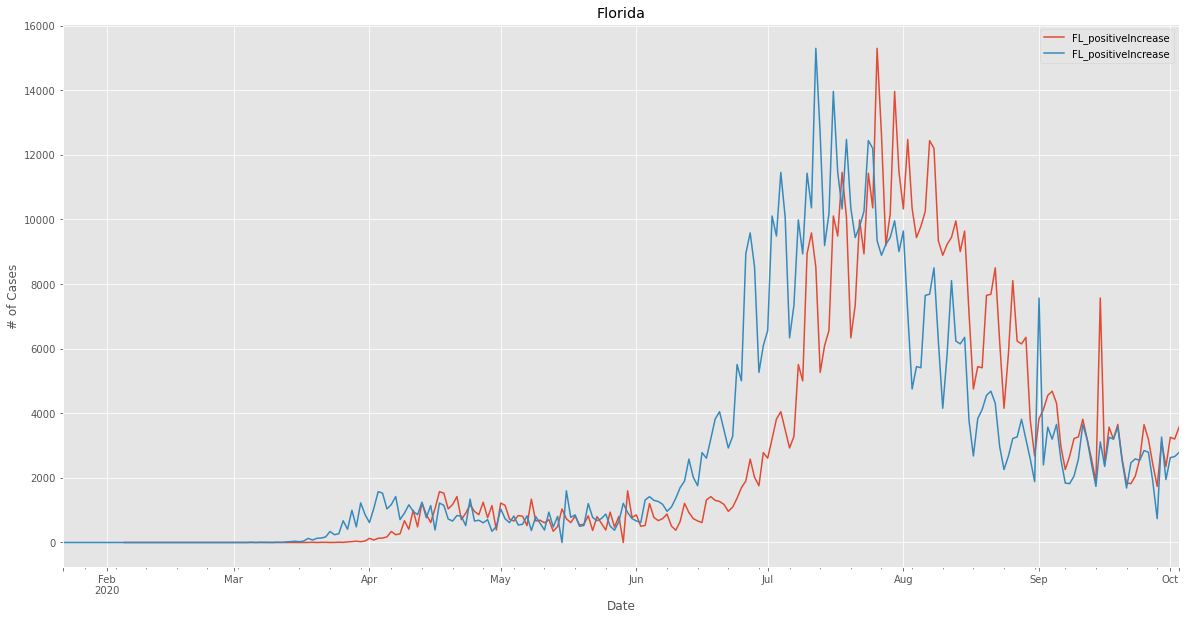

-------------------------------------------------------------
                     TX_positiveIncrease  TX_positiveIncrease
TX_positiveIncrease             1.000000             0.782749
TX_positiveIncrease             0.782749             1.000000


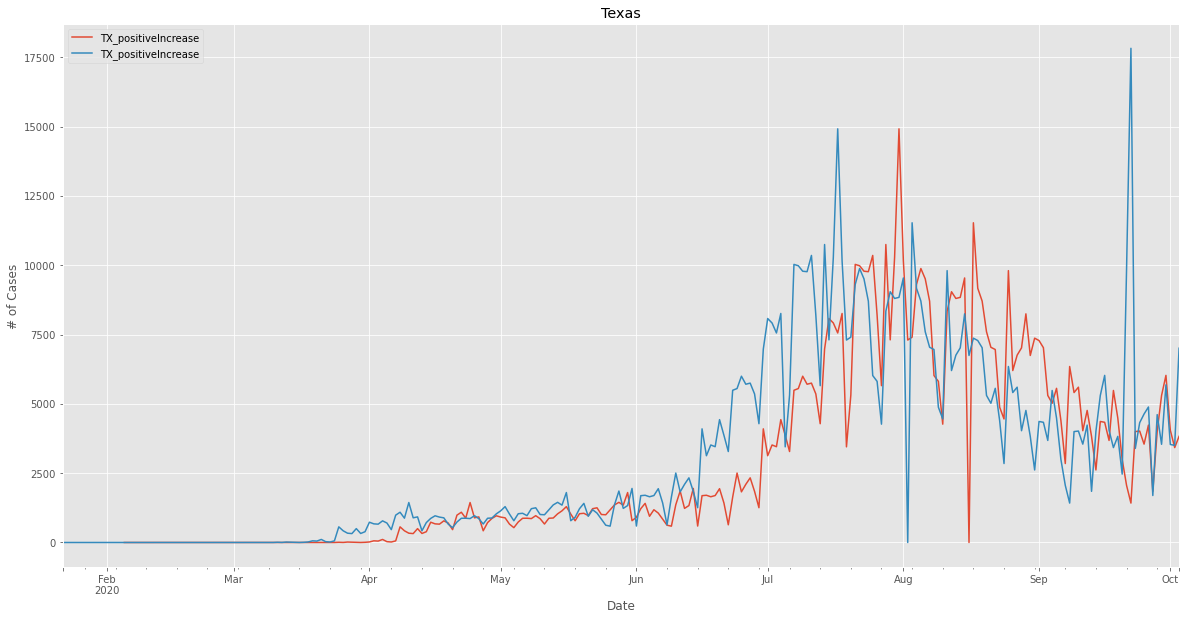

-------------------------------------------------------------


In [12]:
# Loop through and print out the correlation and plots for each 
# lagged dataframe

states = [ga_lag_14, ny_lag_14, fl_lag_14, tx_lag_14]

titles = ['Georgia', 'New York', 'Florida', 'Texas']

for i in range(len(states)):
    print(states[i].corr())
    states[i].plot(figsize=(20, 10))
    plt.xlabel('Date')
    plt.ylabel('# of Cases')
    plt.title(titles[i])
    plt.show();
    print('-------------------------------------------------------------')

So according to these plots, all of these states ()

# Grid Search Parameters

Thanks to the "integrated" nature of ARIMA Time Series Models, we don't need to check for stationarity manually.  Instead, that will take place as we calculate our parameters for the number of auto-regressive terms, differences, and the moving average terms(or the `p, d, q` values).  Calculating the differences will make our model stationary for us!

For now, we'll start small and see what yields the best AIC score.

In [13]:
def pdq_parameters(timeseries, p_range = 2, d_range = 2, q_range = 2, s = 0):
    '''
    Input: Time Series Dataframe, range values for ARIMA(p, d, q), and an 
    optional value for seasonality (s).
    
    The function will generate values between within the given range (default 
    between 0 and 1) for p, d, and q, compile them into lists and run them 
    through a model fit to the given time series.
    
    It will return a list of the parameters and their associate AIC scores.  
    '''

    # Define the p, d and q parameters to take any value between 0 and 2
    p = range(p_range)
    d = range(d_range)
    q = range(q_range)

    # Generate all combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    pdqs = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]

    # Finding optimal results
    results = []
    for combination in pdq:
        for combinations in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(timeseries,
                                                order=combination,
                                                seasonal_order=combinations,
                                                enforce_stationarity=True,
                                                enforce_invertibility=False)

                output = mod.fit()
                results.append([combination, combinations, output.aic])
            
            except:
                continue
    return results

In [14]:
pdq_parameters(ca, 2)

[[(0, 0, 0), (0, 0, 0, 0), 5032.87302448085],
 [(0, 0, 1), (0, 0, 0, 0), 4870.744322823917],
 [(0, 1, 0), (0, 0, 0, 0), 4344.896091834107],
 [(0, 1, 1), (0, 0, 0, 0), 4298.4411279137175],
 [(1, 0, 0), (0, 0, 0, 0), 4360.965877738632],
 [(1, 0, 1), (0, 0, 0, 0), 4318.422369373881],
 [(1, 1, 0), (0, 0, 0, 0), 4330.058384770278],
 [(1, 1, 1), (0, 0, 0, 0), 4291.426497027329]]

If I set the seasonality parameter to "8" (representing the 8 months of covid) our best parameters are (1, 1, 1,) x (1, 1, 1, 8) 

In [15]:
   
    p = range(5)
    d = range(2)
    q = range(5)

    # Generate all combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    pdqs = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]

    # Finding optimal results
    results = []
    for combination in pdq:
        for combinations in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ca,
                                                order=combination,
                                                #seasonal_order=combinations,
                                                enforce_stationarity=True,
                                                enforce_invertibility=False)

                output = mod.fit()
                results.append([combination, combinations, output.aic])
            
            except:
                continue
    

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

In [16]:
results

[[(0, 0, 0), (0, 0, 0), 5032.87302448085],
 [(0, 0, 0), (0, 0, 1), 5032.87302448085],
 [(0, 0, 0), (0, 0, 2), 5032.87302448085],
 [(0, 0, 0), (0, 0, 3), 5032.87302448085],
 [(0, 0, 0), (0, 0, 4), 5032.87302448085],
 [(0, 0, 0), (0, 1, 0), 5032.87302448085],
 [(0, 0, 0), (0, 1, 1), 5032.87302448085],
 [(0, 0, 0), (0, 1, 2), 5032.87302448085],
 [(0, 0, 0), (0, 1, 3), 5032.87302448085],
 [(0, 0, 0), (0, 1, 4), 5032.87302448085],
 [(0, 0, 0), (1, 0, 0), 5032.87302448085],
 [(0, 0, 0), (1, 0, 1), 5032.87302448085],
 [(0, 0, 0), (1, 0, 2), 5032.87302448085],
 [(0, 0, 0), (1, 0, 3), 5032.87302448085],
 [(0, 0, 0), (1, 0, 4), 5032.87302448085],
 [(0, 0, 0), (1, 1, 0), 5032.87302448085],
 [(0, 0, 0), (1, 1, 1), 5032.87302448085],
 [(0, 0, 0), (1, 1, 2), 5032.87302448085],
 [(0, 0, 0), (1, 1, 3), 5032.87302448085],
 [(0, 0, 0), (1, 1, 4), 5032.87302448085],
 [(0, 0, 0), (2, 0, 0), 5032.87302448085],
 [(0, 0, 0), (2, 0, 1), 5032.87302448085],
 [(0, 0, 0), (2, 0, 2), 5032.87302448085],
 [(0, 0, 0)

In [17]:
for i in range(len(results)):
    print(results[i])

[(0, 0, 0), (0, 0, 0), 5032.87302448085]
[(0, 0, 0), (0, 0, 1), 5032.87302448085]
[(0, 0, 0), (0, 0, 2), 5032.87302448085]
[(0, 0, 0), (0, 0, 3), 5032.87302448085]
[(0, 0, 0), (0, 0, 4), 5032.87302448085]
[(0, 0, 0), (0, 1, 0), 5032.87302448085]
[(0, 0, 0), (0, 1, 1), 5032.87302448085]
[(0, 0, 0), (0, 1, 2), 5032.87302448085]
[(0, 0, 0), (0, 1, 3), 5032.87302448085]
[(0, 0, 0), (0, 1, 4), 5032.87302448085]
[(0, 0, 0), (1, 0, 0), 5032.87302448085]
[(0, 0, 0), (1, 0, 1), 5032.87302448085]
[(0, 0, 0), (1, 0, 2), 5032.87302448085]
[(0, 0, 0), (1, 0, 3), 5032.87302448085]
[(0, 0, 0), (1, 0, 4), 5032.87302448085]
[(0, 0, 0), (1, 1, 0), 5032.87302448085]
[(0, 0, 0), (1, 1, 1), 5032.87302448085]
[(0, 0, 0), (1, 1, 2), 5032.87302448085]
[(0, 0, 0), (1, 1, 3), 5032.87302448085]
[(0, 0, 0), (1, 1, 4), 5032.87302448085]
[(0, 0, 0), (2, 0, 0), 5032.87302448085]
[(0, 0, 0), (2, 0, 1), 5032.87302448085]
[(0, 0, 0), (2, 0, 2), 5032.87302448085]
[(0, 0, 0), (2, 0, 3), 5032.87302448085]
[(0, 0, 0), (2, 

[(4, 0, 3), (0, 0, 0), 4292.952721068706]
[(4, 0, 3), (0, 0, 1), 4292.952721068706]
[(4, 0, 3), (0, 0, 2), 4292.952721068706]
[(4, 0, 3), (0, 0, 3), 4292.952721068706]
[(4, 0, 3), (0, 0, 4), 4292.952721068706]
[(4, 0, 3), (0, 1, 0), 4292.952721068706]
[(4, 0, 3), (0, 1, 1), 4292.952721068706]
[(4, 0, 3), (0, 1, 2), 4292.952721068706]
[(4, 0, 3), (0, 1, 3), 4292.952721068706]
[(4, 0, 3), (0, 1, 4), 4292.952721068706]
[(4, 0, 3), (1, 0, 0), 4292.952721068706]
[(4, 0, 3), (1, 0, 1), 4292.952721068706]
[(4, 0, 3), (1, 0, 2), 4292.952721068706]
[(4, 0, 3), (1, 0, 3), 4292.952721068706]
[(4, 0, 3), (1, 0, 4), 4292.952721068706]
[(4, 0, 3), (1, 1, 0), 4292.952721068706]
[(4, 0, 3), (1, 1, 1), 4292.952721068706]
[(4, 0, 3), (1, 1, 2), 4292.952721068706]
[(4, 0, 3), (1, 1, 3), 4292.952721068706]
[(4, 0, 3), (1, 1, 4), 4292.952721068706]
[(4, 0, 3), (2, 0, 0), 4292.952721068706]
[(4, 0, 3), (2, 0, 1), 4292.952721068706]
[(4, 0, 3), (2, 0, 2), 4292.952721068706]
[(4, 0, 3), (2, 0, 3), 4292.952721

In [50]:
# Finding minumum AIC value
aic = []
for i in range(len(results)):
    aic.append(results[i][2])  
# Finding the parameters for the minimum AIC
#for i in range(len(results)):
    if results[i][2] == min(aic):
        print(results[i])
    

In [18]:
function = pdq_parameters(ca, 5, 3, 5, 8)

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum 

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [19]:
for i in range(len(function)):
    print(function[i])

[(0, 0, 0), (0, 0, 0, 8), 5032.87302448085]
[(0, 0, 0), (0, 0, 1, 8), 4808.680435121736]
[(0, 0, 0), (0, 0, 2, 8), 4716.273379688193]
[(0, 0, 0), (0, 0, 3, 8), 4642.5327646487285]
[(0, 0, 0), (0, 0, 4, 8), 4593.73084308044]
[(0, 0, 0), (0, 1, 0, 8), 4366.919895174464]
[(0, 0, 0), (0, 1, 1, 8), 4361.891704772591]
[(0, 0, 0), (0, 1, 2, 8), 4366.604277709997]
[(0, 0, 0), (0, 1, 3, 8), 4350.1193072658925]
[(0, 0, 0), (0, 1, 4, 8), 4352.027589089707]
[(0, 0, 0), (0, 2, 0, 8), 4439.58773145692]
[(0, 0, 0), (0, 2, 1, 8), 4255.6614065650465]
[(0, 0, 0), (0, 2, 2, 8), 4250.64148810121]
[(0, 0, 0), (0, 2, 3, 8), 4250.6186052827925]
[(0, 0, 0), (0, 2, 4, 8), 4236.307379832105]
[(0, 0, 0), (1, 0, 0, 8), 4511.704938516035]
[(0, 0, 0), (1, 0, 1, 8), 4508.373893413724]
[(0, 0, 0), (1, 0, 2, 8), 4512.268113504905]
[(0, 0, 0), (1, 0, 3, 8), 4494.562744475762]
[(0, 0, 0), (1, 0, 4, 8), 4496.372371292318]
[(0, 0, 0), (1, 1, 0, 8), 4360.580188547703]
[(0, 0, 0), (1, 1, 1, 8), 4363.551511568502]
[(0, 0, 0)

[(2, 0, 2), (0, 2, 3, 8), 4256.596646881257]
[(2, 0, 2), (0, 2, 4, 8), 4257.611230044232]
[(2, 0, 2), (1, 0, 0, 8), 4306.604948546197]
[(2, 0, 2), (1, 0, 1, 8), 4311.656283189865]
[(2, 0, 2), (1, 0, 2, 8), 4307.322428193902]
[(2, 0, 2), (1, 0, 3, 8), 4309.164942527757]
[(2, 0, 2), (1, 0, 4, 8), 4309.494388218343]
[(2, 0, 2), (1, 1, 0, 8), 4262.433292326023]
[(2, 0, 2), (1, 1, 1, 8), 4199.2744146339355]
[(2, 0, 2), (1, 1, 2, 8), 4209.704731876877]
[(2, 0, 2), (1, 1, 3, 8), 4226.042869320952]
[(2, 0, 2), (1, 1, 4, 8), 4227.974944388783]
[(2, 0, 2), (1, 2, 0, 8), 4305.208072690226]
[(2, 0, 2), (1, 2, 1, 8), 4262.292651949903]
[(2, 0, 2), (1, 2, 2, 8), 4256.602568094555]
[(2, 0, 2), (1, 2, 3, 8), 4257.717973240521]
[(2, 0, 2), (1, 2, 4, 8), 4259.327191601251]
[(2, 0, 2), (2, 0, 0, 8), 4318.895527241615]
[(2, 0, 2), (2, 0, 1, 8), 4307.3598350032635]
[(2, 0, 2), (2, 0, 2, 8), 4309.16930647029]
[(2, 0, 2), (2, 0, 3, 8), 4311.210808585757]
[(2, 0, 2), (2, 0, 4, 8), 4311.097835808002]
[(2, 0, 2

[(4, 1, 1), (1, 2, 0, 8), 4289.588610419455]
[(4, 1, 1), (1, 2, 1, 8), 4158.183512758998]
[(4, 1, 1), (1, 2, 2, 8), 4250.945419949034]
[(4, 1, 1), (1, 2, 3, 8), 4247.461107720669]
[(4, 1, 1), (1, 2, 4, 8), 4257.708697272629]
[(4, 1, 1), (2, 0, 0, 8), 4285.845846791829]
[(4, 1, 1), (2, 0, 1, 8), 4287.342916210143]
[(4, 1, 1), (2, 0, 2, 8), 4289.205302355134]
[(4, 1, 1), (2, 0, 3, 8), 4288.8017563569565]
[(4, 1, 1), (2, 0, 4, 8), 4290.401952326823]
[(4, 1, 1), (2, 1, 0, 8), 4214.2790861296135]
[(4, 1, 1), (2, 1, 1, 8), 4183.194877068875]
[(4, 1, 1), (2, 1, 2, 8), 4213.124838151478]
[(4, 1, 1), (2, 1, 3, 8), 4214.853612826919]
[(4, 1, 1), (2, 1, 4, 8), 4214.992797024497]
[(4, 1, 1), (2, 2, 0, 8), 4219.919352695759]
[(4, 1, 1), (2, 2, 1, 8), 4119.877467935245]
[(4, 1, 1), (2, 2, 2, 8), 4177.330262929272]
[(4, 1, 1), (2, 2, 3, 8), 4257.086808263266]
[(4, 1, 1), (2, 2, 4, 8), 4259.217031072413]
[(4, 1, 1), (3, 0, 0, 8), 4286.749502498051]
[(4, 1, 1), (3, 0, 1, 8), 4288.647348024339]
[(4, 1, 

In [36]:
# Finding minumum AIC value
aic = []
for i in range(len(function)):
    aic.append(function[i][2])
    
# Finding the parameters for the minimum AIC
for i in range(len(function)):
    if function[i][2] == min(aic):
        print(function[i])
    

[(3, 2, 1), (1, 2, 2, 8), 4096.765848692685]


nope


[]